In [167]:
import pandas as pd

data = pd.read_excel('hackaton_data_5post.xlsx')
data.head()

,ADDRESS,CITY,REGION,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly
0,"г.Калуга, Литейная ул., 25/15",КАЛУГА,Калужская область,NaN,3.3,NaN,13.0,1.0,7696.0,10099,3382,324698,0,0,NaN,остановка,423321
1,"г.Калуга, Гагарина ул., 1",КАЛУГА,Калужская область,NaN,NaN,NaN,NaN,NaN,6369.0,10068,3236,324698,1,1,NaN,остановка,423321
2,"г.Калуга, Кибальчича ул., 25",КАЛУГА,Калужская область,NaN,3.1,NaN,12.0,1.0,5553.0,10100,3436,324698,1,0,NaN,NaN,423321
3,"г.Калуга, Пестеля ул., 60/49",КАЛУГА,Калужская область,3.0,2.2,0.0,12.0,1.0,7162.0,10099,3257,324698,0,0,NaN,NaN,423321
4,"г.Калуга, Ленина ул., 81",КАЛУГА,Калужская область,1.0,2.0,0.0,9.0,1.0,6269.0,10096,3195,324698,1,0,NaN,остановка,423321


In [168]:
def replace_binary_value(b):
    if b and pd.notnull(b):
        return 1
    else:
        return -1

data.iloc[:, 12:16] = data.iloc[:, 12:16].agg(lambda row: row.agg(replace_binary_value, axis=0), axis=1)

data_kal_obl = data[data['REGION'] == 'Калужская область']
data_tul_obl = data[data['REGION'] == 'Тульская область']

Построим графики попарных распределений признаков и целевых переменных:

/Users/kostya/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kostya/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


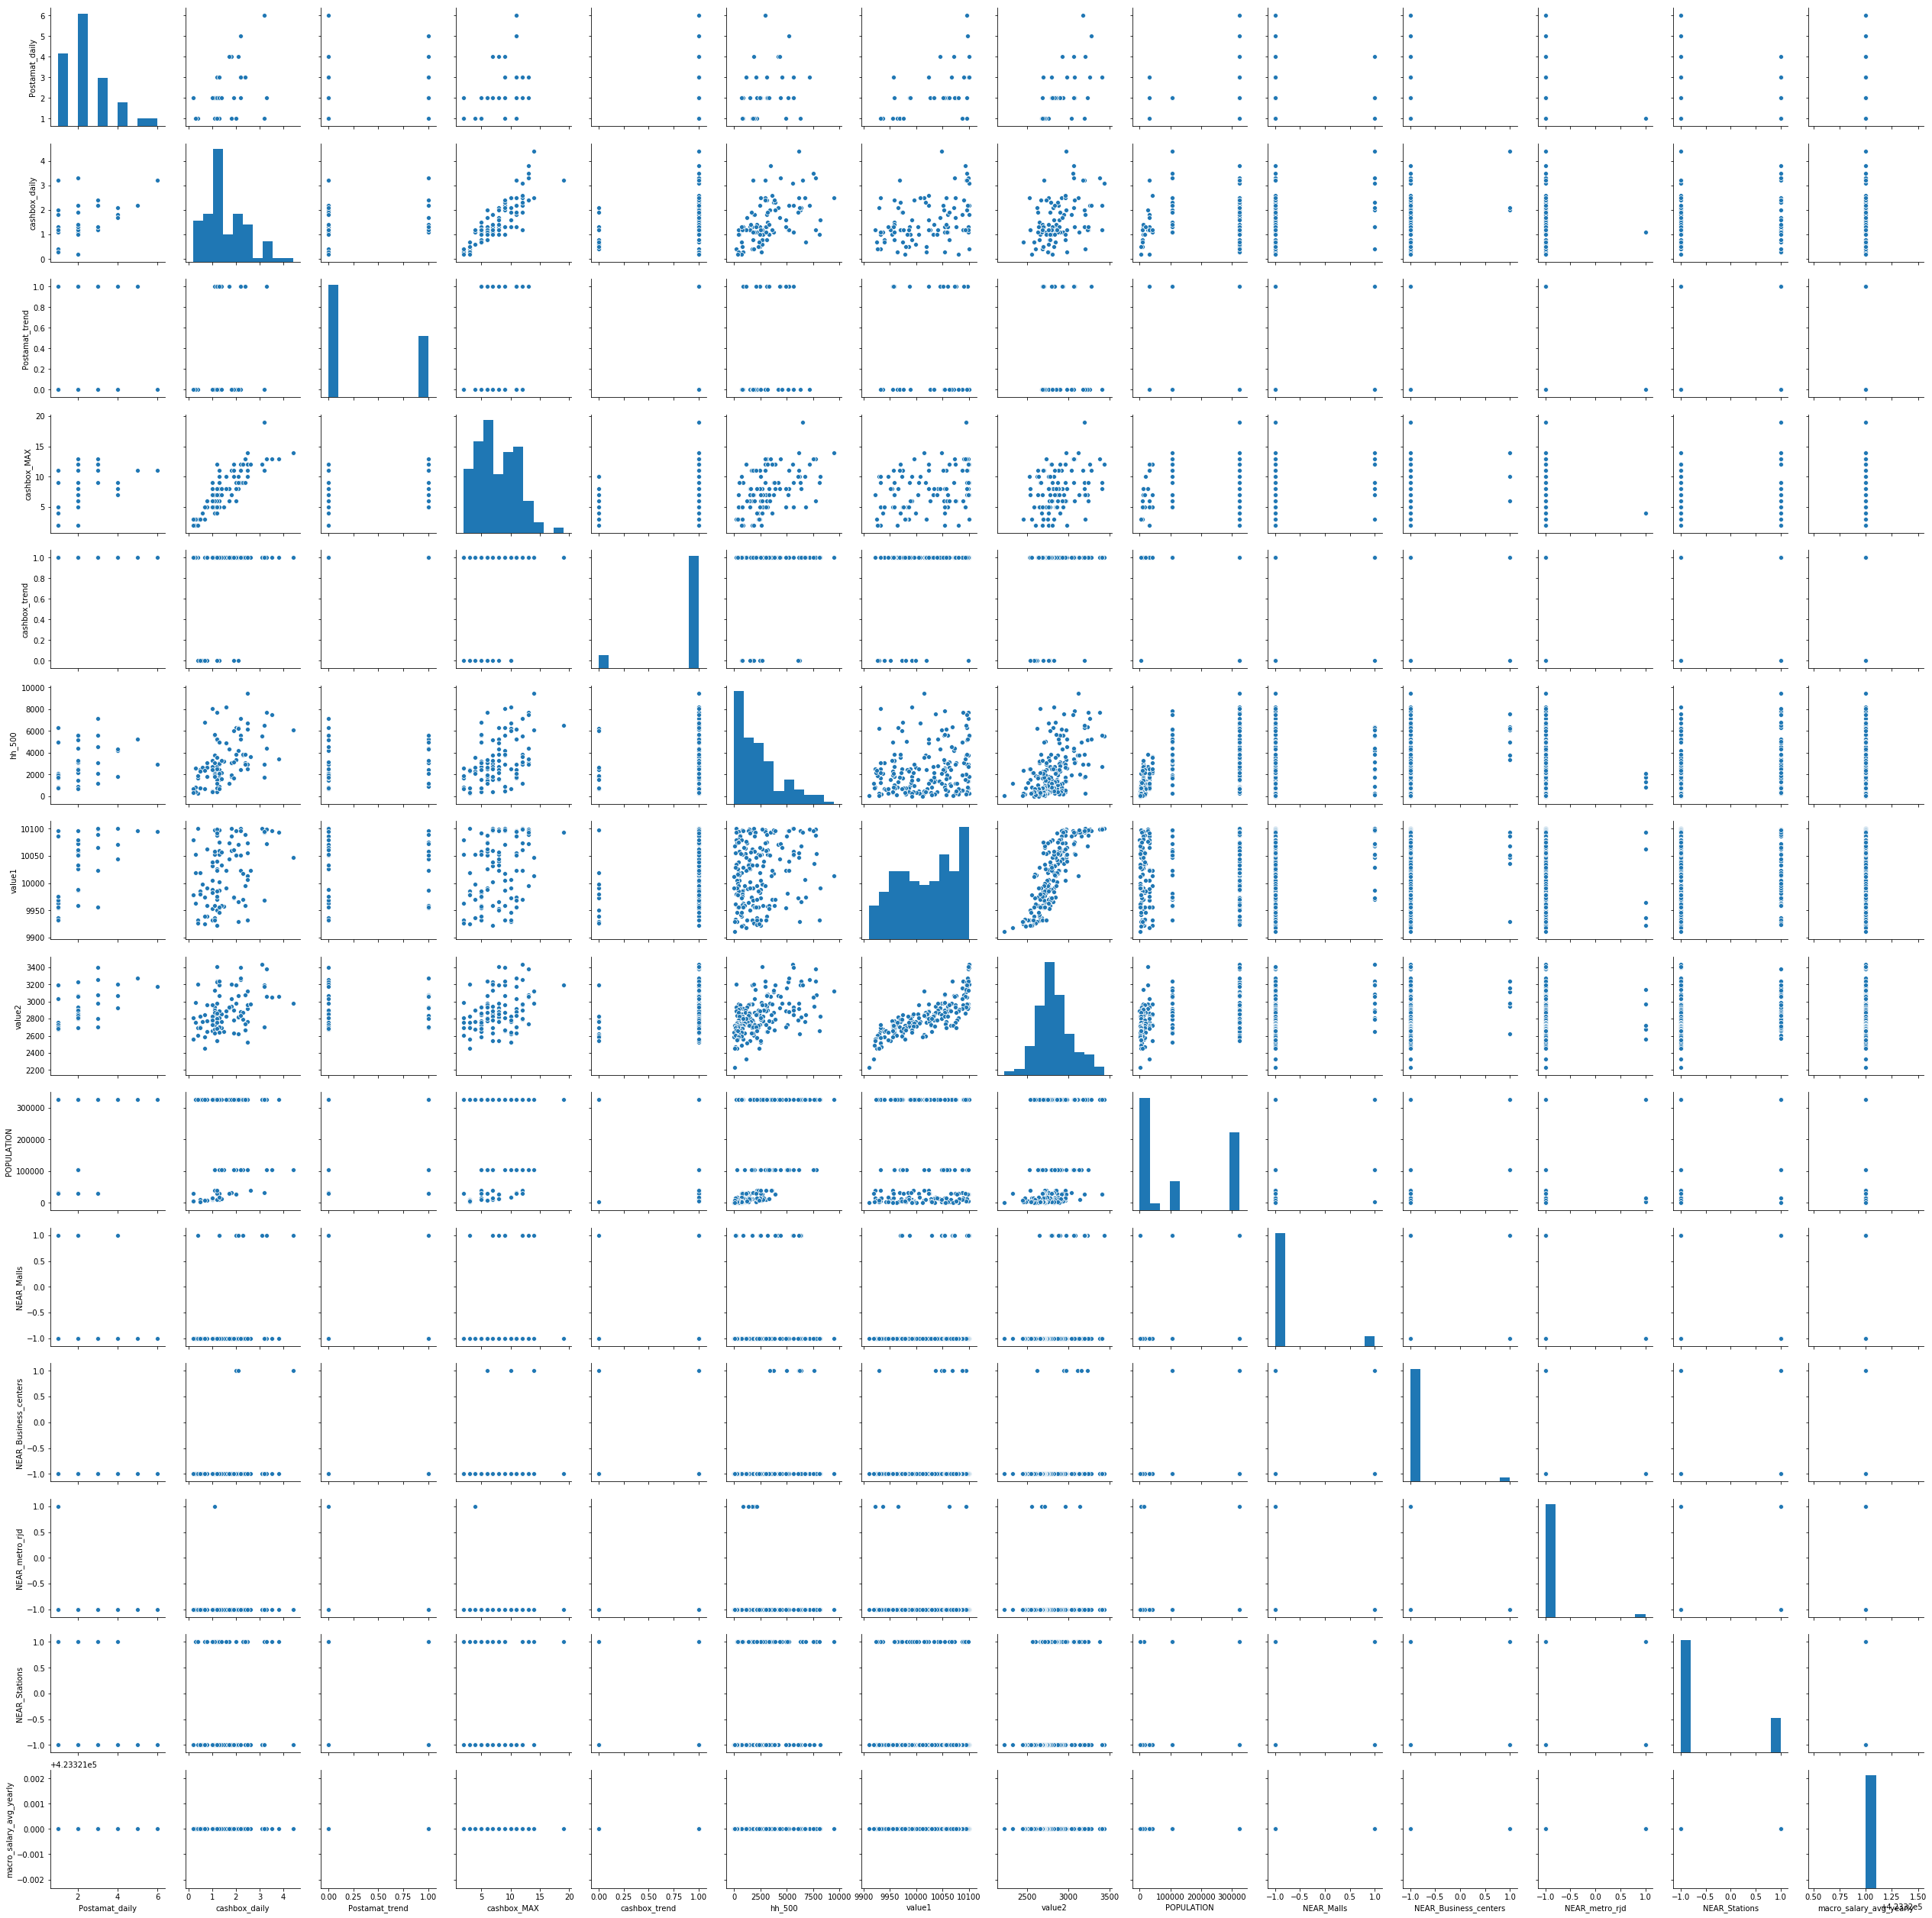

In [145]:
import seaborn as sns

sns.pairplot(data_kal_obl.iloc[:, 3:17])

Видно, что города с большим населением (областные центры, т.е. Калуга и Тула) выбиваются из общего распределения, следовательно их надо рассматирвать отдельно

In [169]:
data_kaluga = data_kal_obl[data_kal_obl['CITY'] == 'КАЛУГА']
data_tula = data_tul_obl[data_tul_obl['CITY'] == 'ТУЛА']
data_kal_obl = data_kal_obl[data_kal_obl['CITY'] != 'КАЛУГА']
data_tul_obl = data_tul_obl[data_tul_obl['CITY'] != 'ТУЛА']

Найдем сначала зависимость среднего количества посылок, выданных в кассе

In [170]:
X = data_kaluga[data_kaluga['cashbox_daily'].notnull()].iloc[:, 6:18]

In [171]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 239
Data columns (total 11 columns):
cashbox_MAX                57 non-null float64
cashbox_trend              55 non-null float64
hh_500                     57 non-null float64
value1                     57 non-null int64
value2                     57 non-null int64
POPULATION                 57 non-null int64
NEAR_Malls                 57 non-null int64
NEAR_Business_centers      57 non-null int64
NEAR_metro_rjd             57 non-null int64
NEAR_Stations              57 non-null int64
macro_salary_avg_yearly    57 non-null int64
dtypes: float64(3), int64(8)
memory usage: 5.3 KB


In [172]:
X.describe()

,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly
count,57.000000,55.000000,57.000000,57.000000,57.000000,57.0,57.000000,57.000000,57.000000,57.000000,57.0
mean,7.701754,0.836364,3839.456140,10023.807018,2926.052632,324698.0,-0.754386,-0.964912,-0.964912,-0.052632,423321.0
std,3.545444,0.373355,2302.232566,58.251744,225.818544,0.0,0.662266,0.264906,0.264906,1.007491,0.0
min,2.000000,0.000000,237.000000,9927.000000,2543.000000,324698.0,-1.000000,-1.000000,-1.000000,-1.000000,423321.0
25%,5.000000,1.000000,2127.000000,9973.000000,2766.000000,324698.0,-1.000000,-1.000000,-1.000000,-1.000000,423321.0
50%,8.000000,1.000000,3105.000000,10019.000000,2870.000000,324698.0,-1.000000,-1.000000,-1.000000,-1.000000,423321.0
75%,10.000000,1.000000,5619.000000,10088.000000,3075.000000,324698.0,-1.000000,-1.000000,-1.000000,1.000000,423321.0
max,19.000000,1.000000,9463.000000,10100.000000,3436.000000,324698.0,1.000000,1.000000,1.000000,1.000000,423321.0


Обработаем признаки и целевые переменные:

In [173]:
del X['POPULATION']
del X['macro_salary_avg_yearly']

Мы удалили эти столюцы, так как в них везде одинаковые значения

In [174]:
import numpy as np

X.fillna(0, inplace=True)
X = (X - X.mean()) / X.std()

In [175]:
y = data_kaluga[data_kaluga['cashbox_daily'].notnull()]['cashbox_daily']
y = (y - y.mean()) / y.std()

In [176]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

lasso = Lasso(0.05)
ridge = Ridge()
lin_reg = LinearRegression()

Проверим, что модель Лассо адекватно приближает значения:

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

lasso.fit(X_train, y_train)
print(mse(y_test, lasso.predict(X_test)), mae(y_test, lasso.predict(X_test)))

0.23077393166204443 0.4375351949895522


Применим модель Лассо для отбора значащих признаков:

In [179]:
lasso.fit(X, y)
lasso.coef_

array([ 0.7950587 ,  0.        ,  0.        ,  0.04516096,  0.05593081,
       -0.        ,  0.        ,  0.01609916, -0.06898949])

In [180]:
X.corr()

,cashbox_MAX,cashbox_trend,hh_500,value1,value2,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations
cashbox_MAX,1.000000,0.300054,0.514976,0.397362,0.437021,0.046965,0.087393,-0.140762,0.050518
cashbox_trend,0.300054,1.000000,0.261985,0.436464,0.419984,0.047525,-0.273268,-0.273268,0.018744
hh_500,0.514976,0.261985,1.000000,0.149227,0.330607,-0.130335,0.138233,-0.100281,-0.039715
value1,0.397362,0.436464,0.149227,1.000000,0.910581,0.313233,-0.219422,-0.203222,-0.080200
value2,0.437021,0.419984,0.330607,0.910581,1.000000,0.312035,-0.180929,-0.146899,-0.017491
NEAR_Malls,0.046965,0.047525,-0.130335,0.313233,0.312035,1.000000,-0.050000,-0.050000,-0.033806
NEAR_Business_centers,0.087393,-0.273268,0.138233,-0.219422,-0.180929,-0.050000,1.000000,-0.017857,-0.126773
NEAR_metro_rjd,-0.140762,-0.273268,-0.100281,-0.203222,-0.146899,-0.050000,-0.017857,1.000000,0.140859
NEAR_Stations,0.050518,0.018744,-0.039715,-0.080200,-0.017491,-0.033806,-0.126773,0.140859,1.000000


Признаки value1 и value2 получили ненулевые веса, однако у них большая корреляция, поэтому один из них не надо учитывать. Посчитаем веса у всех признаков с отсутствующими value2 и value1:

In [181]:
lasso.fit(X.drop(labels='value1', axis=1), y)
lasso.coef_

array([ 0.7949395 ,  0.        ,  0.        ,  0.09664327, -0.        ,
        0.        ,  0.01323896, -0.07149039])

In [182]:
lasso.fit(X.drop(labels='value2', axis=1), y)
lasso.coef_

array([ 0.79889328,  0.        ,  0.00198145,  0.09487306, -0.        ,
        0.        ,  0.01836106, -0.0664145 ])

При отсутвуещем value2 вес признака hh_500 перестает быть нулевым, то есть имеется какая-то неявная зависимоть между value2 и hh_500, но нет зависимотсти между hh_500 и value1 (также можно заметить, что корреляция между этими парами признаков отличаются больше, чем в два раза). Поэтому следует оставить value1.

In [183]:
X.drop(labels=['cashbox_trend', 'value2', 'NEAR_Malls', 'NEAR_Business_centers'], axis=1, inplace=True)

In [184]:
X.head()

,cashbox_MAX,hh_500,value1,NEAR_metro_rjd,NEAR_Stations
0,1.494381,1.675132,1.290828,-0.132453,1.044805
2,1.212329,0.744297,1.307995,-0.132453,-0.940325
3,1.212329,1.443183,1.290828,-0.132453,-0.940325
4,0.366173,1.055299,1.239327,-0.132453,1.044805
6,-0.479983,1.678173,1.101992,-0.132453,1.044805


In [185]:
def test_regressor(X, y, regressor):
    mean_mse = 0
    mean_mae = 0
    
    for i in range(100):
        X_train , X_test, y_train, y_test = train_test_split(X, y)
        regressor.fit(X_train, y_train)
        mean_mse += mse(y_test, regressor.predict(X_test))
        mean_mae += mae(y_test, regressor.predict(X_test))
        
    print('MSE = ', mean_mse/100)
    print('MAE = ', mean_mae/100)

Выявим лучшую модель линейной регрессии:

In [186]:
print('LinReg:')
test_regressor(X, y, lin_reg)

print('Lasso:')
test_regressor(X, y, lasso)

print('Ridge:')
test_regressor(X, y, ridge)

LinReg:
MSE =  0.23783567209531814
MAE =  0.38517080494372846
Lasso:
MSE =  0.23136067335622254
MAE =  0.3750200361262386
Ridge:
MSE =  0.2532384232460702
MAE =  0.39392302566386284


Большого различия в точности между ними нет, однако чуть точнее все-таки Ridge.
Далее изучим точности некоторых других регрессионых моделей: 

In [187]:
from sklearn.tree import DecisionTreeRegressor

des_tree = DecisionTreeRegressor()

print('DesTree:')
test_regressor(X, y, des_tree)

DesTree:
MSE =  0.46593150768004554
MAE =  0.5133844478204356


In [188]:
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor()

print('ExtraTree:')
test_regressor(X, y, extra_tree)

ExtraTree:
MSE =  0.5055772119657973
MAE =  0.5368234384905087


In [189]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

print('KNN:')
test_regressor(X, y, knn)

KNN:
MSE =  0.38581897859290115
MAE =  0.4724485249846089


Видно, что модель Ridge оказалась наилучшей. На остальных датасетах применим ту же стратегию (в силу идентичности данных, различий не будет)